In [1]:
# from statistics import median
import pickle

import matplotlib.pyplot as plt
import nmrglue as ng
import numpy as np

import global_constants as glob
import operators as op
import tomography_helper_functions as helper
from coeff_groups_class import CoefficientGroups
from phase import autophase_0
from plot_dm import plot_complex_density_matrix
from temporal_average import temporal_average

plt.rcParams['figure.dpi'] = glob.DPI_DISPLAY

# Importing Data
Rearranged folders (from Donny's usual format) so that both P1 and P2 files are in the same folder. This way I don't have to deal with separate "P1" and "P2" folders.

findfont: Font family ['STIXSizeTwoSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeThreeSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['DejaVu Sans Mono'] not found. Falling back to DejaVu Sans.


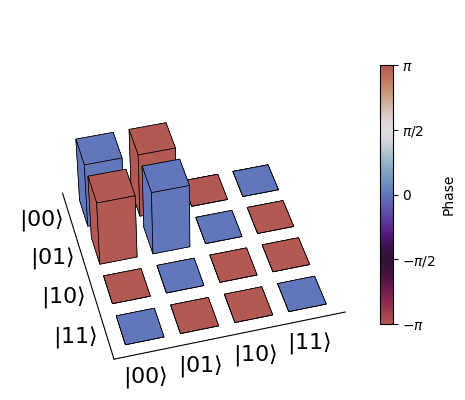

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 5.00000000e-01 -5.00000000e-01 -5.04378831e-17  3.89411472e-17]
 [-5.00000000e-01  5.00000000e-01  3.89411472e-17 -2.74444113e-17]
 [-2.77555756e-17  3.92523115e-17 -1.14967359e-17 -1.62588398e-17]
 [ 3.92523115e-17 -3.68712595e-17 -1.62588398e-17  2.38105196e-18]]

In [2]:
state_name = "0001CNP_ns1_109"
NO_IDENTITY = False

PH_0_P1_OFFSET = 180
PH_0_P2_OFFSET = 0


HAD_I= op.Rx_I(np.pi) * op.Ry_I(np.pi / 2)
HAD_S= op.Rx_S(np.pi) * op.Ry_S(np.pi / 2)
state_name = "DCR3"
rho_theory = HAD_I * HAD_S * op.CLEAN_0100 * HAD_S.dag() * HAD_I.dag()
rho_theory =HAD_I * rho_theory * HAD_I.dag()


plot_complex_density_matrix(rho_theory)
display(rho_theory)

In [3]:
data_folder = r"C:\Users\donny\Desktop\desktop_files\Brown\All_data\2_19_2025\SAMPLE_143_19_Feb_25\DCR3_151"

Flip the frequency axis

# Calculating the frequency axis for the spectrum
All data in below cell is from Donny's email & Bruker plots

According to Bruker's software, the middle of the spectrum should be the experimental larmor frequency (with chemical shift included), and we can set this to 0 Hz. In other words, the frequency axis range is: (-spectrum_width/2, spectrum/2), with 0 in the middle, and left peak should occur at -$J$ and right peak at $J$

In [4]:
freqs, all_spectra_complex = temporal_average(data_folder, AQ=2.2, remove_digital=True, PHASE_0=0)
mid = all_spectra_complex.shape[0] // 2

In [5]:
# DIFFERENT FOR THIS MEASUREMENT!
SPECTRUM_WIDTH = 2000  # Hz

freqs_local = np.linspace(-SPECTRUM_WIDTH / 2, SPECTRUM_WIDTH / 2, all_spectra_complex.shape[1])

# assert np.array_equal(freqs, freqs_local)

B_0 = 14.0921  # Tesla
J = 21.97  # Hz (Based on Donny's text)
L_FREQ = -J / 2
R_FREQ = J / 2

# probably won't need...?
SPECTRUM_OFFSET = 49697.66
w_1_Bruker = 202474441.0  # Hz
w_2_Bruker = 202475194.8  # Hz
TEMP = 310  # Kelvin

# Plotting Everything Together

Adjust 0th order phase:
- Adjusting P1 spectra using X1 imag $(L+R = I_{1z},\quad L-R = I_{1z} I_{2z})$
- Adjusting P2 spectra using X2 imag $(L+R = I_{2z},\quad L-R = I_{1z} I_{2z})$

In [6]:
PHASE_WIDTH = 200  # number of points to include in the auto-phasing
spectrum_p1x1 = all_spectra_complex[1]  # P1 X1 (L+R = I_1z, L-R = I_1z I_2z)
ph_0_p1 = autophase_0(spectrum_p1x1, PHASE_WIDTH)
all_spectra_complex[:mid] = np.array([ng.proc_base.ps(s, p0=ph_0_p1 + PH_0_P1_OFFSET, p1=0) for s in all_spectra_complex[:mid]])

spectrum_p2x2 = all_spectra_complex[10]  # P2 X2 (L+R = I_2z, L-R = I_1z I_2z)
ph_0_p2 = autophase_0(spectrum_p2x2, PHASE_WIDTH)
all_spectra_complex[mid:] = np.array([ng.proc_base.ps(s, p0=ph_0_p2 + PH_0_P2_OFFSET, p1=0) for s in all_spectra_complex[mid:]])

print(ph_0_p1 + PH_0_P1_OFFSET, ph_0_p2 + PH_0_P2_OFFSET)

290.5 14.5


In [7]:
all_spectra = np.zeros((all_spectra_complex.shape[0] * 2, all_spectra_complex.shape[1]))

for i in range(all_spectra_complex.shape[0]):
    all_spectra[i * 2, :] = all_spectra_complex[i, :].real
    all_spectra[i * 2 + 1, :] = all_spectra_complex[i, :].imag

all_spectra.shape

(28, 4410)

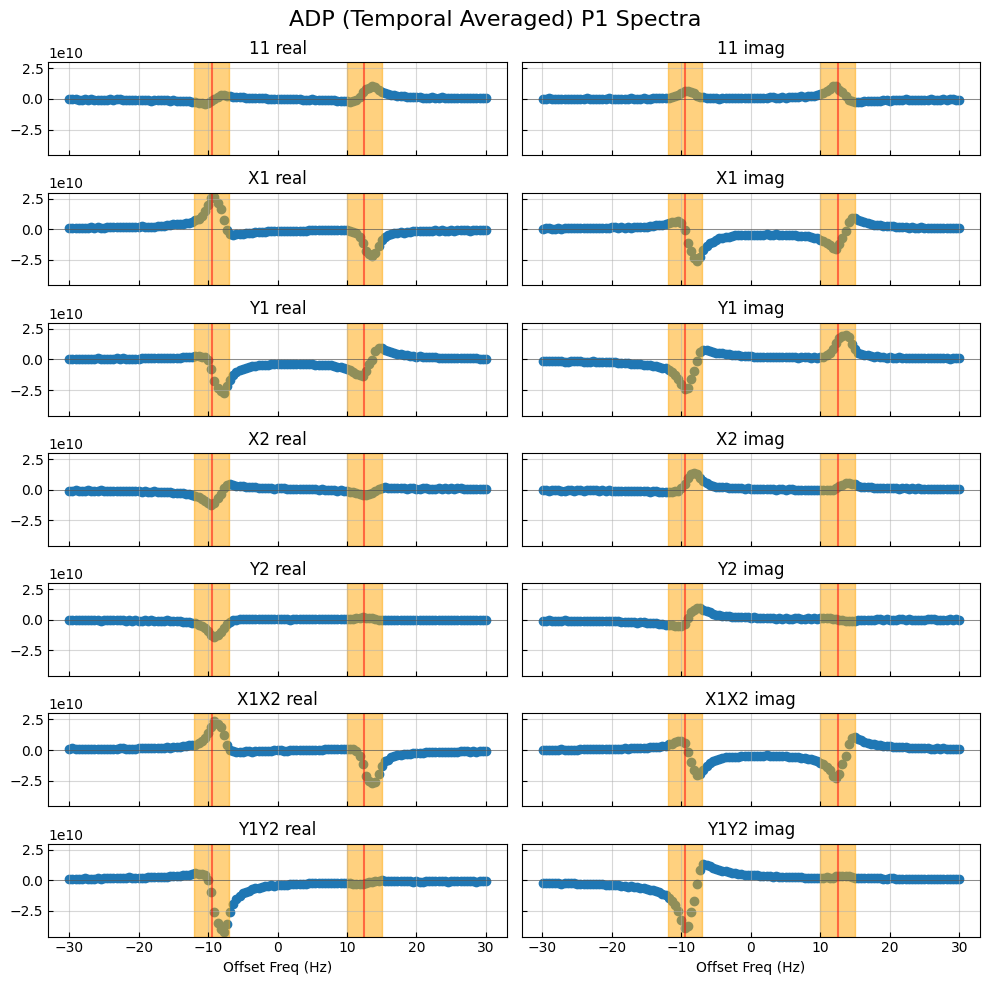

In [8]:
INT_WIDTH = 5  # in Hz. The width to integrate over.
X_LIMS_DISPLAY = [-30, 30]

# Making an offset so the red lines visually line up with the peaks
p1_offset = 1.5
p1_freqs = (L_FREQ + p1_offset, R_FREQ + p1_offset)

fig_1, axs_1 = helper.plot_spectra_together(freqs, all_spectra[:all_spectra.shape[0] // 2],
                                            glob.SPECTRA_NAMES, X_LIMS_DISPLAY, p1_freqs[0], p1_freqs[1],
                                            int_width=INT_WIDTH, share_y=True)
fig_1.suptitle('ADP (Temporal Averaged) P1 Spectra', size=16)
fig_1.tight_layout()
plt.show()

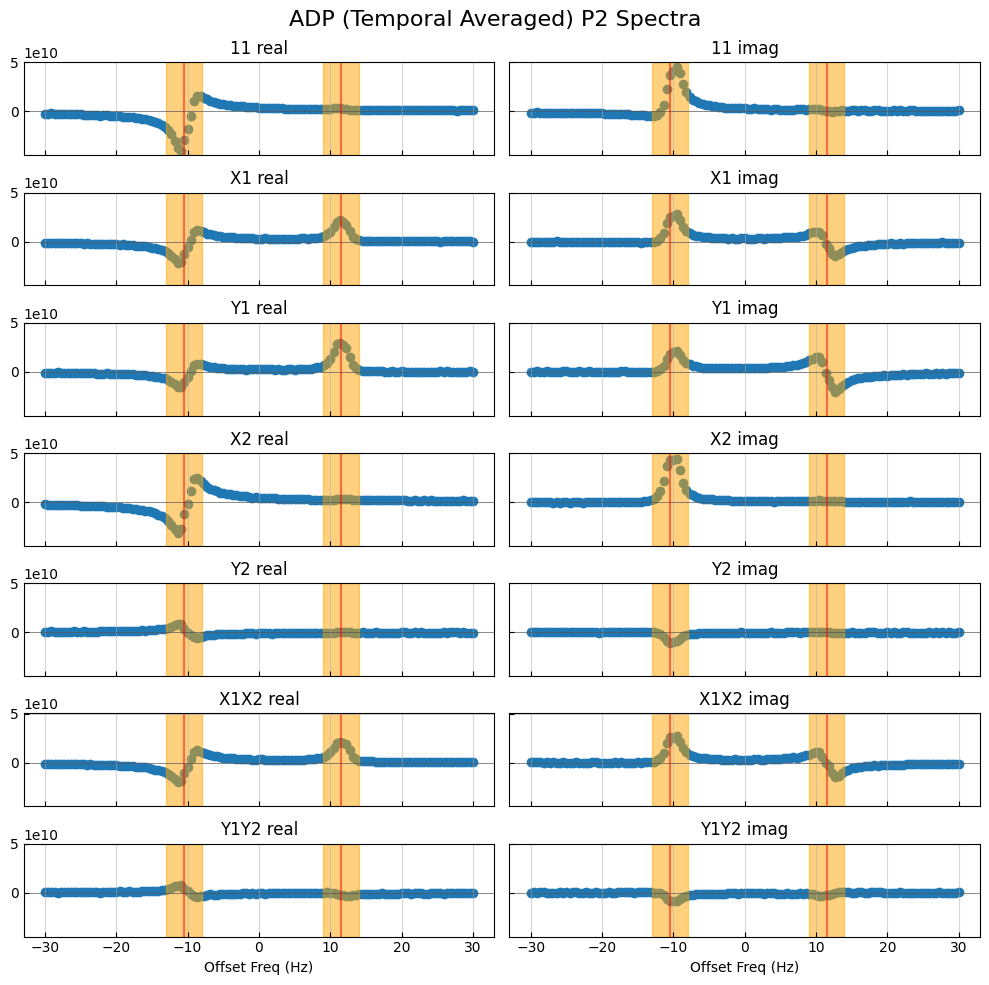

In [9]:
# Making an offset so the red lines visually line up with the peaks
p2_offset = .5
p2_freqs = (L_FREQ + p2_offset, R_FREQ + p2_offset)

fig_2, axs_2 = helper.plot_spectra_together(freqs, all_spectra[all_spectra.shape[0] // 2:], glob.SPECTRA_NAMES,
                                            X_LIMS_DISPLAY, p2_freqs[0], p2_freqs[1], int_width=INT_WIDTH, share_y=True)
fig_2.suptitle('ADP (Temporal Averaged) P2 Spectra', size=16)
fig_2.tight_layout()
plt.show()


# Preparing for Tomography Calculations:

We use convention of using the "I" to denote the first spin ($I_1$) and "S" the second spin ($I_2$)

$(I=I_1, S=I_2)$

Quick Check that our pulse sequences covers all 15 basis operators (not necessary)

In [10]:
op.check_basis_complete()

Operator basis is complete (15 elements)


# Three Methods for calculating coefficients

1. Just the height of the spectrum at the expected peak locations
2. Integration of peaks (simpson method & trapezoid method, but both seem to give almost identical answers)
3. (no longer used) Fitting a theoretical Lorentzian model to our data using scipy.curve_fit

## First approach: get height of one data point closest to theoretical peak locations

### Construct a "`coefficient groups`". 
"coefficient groups" is a list of "group"s, with each group being a list of:

`[operator, (c1, spectrum type), (c2, spectrum type), (c3, spectrum type), ...]`

where the first element of the group is a product operator,

and the following elements are tuples of: (coefficients corresponding to that operator, the type of spectrum which the coefficient came from).

In the case of ADP there are two spectrum types: P1 and P2

(each spectrum produces two coefficients)

In [11]:
coeff_groups_height = CoefficientGroups()

for (i, spectrum) in enumerate(all_spectra):
    # Height of the point closest to each peak's frequency location
    L = spectrum[np.absolute(freqs - L_FREQ).argmin()]
    R = spectrum[np.absolute(freqs - R_FREQ).argmin()]
    coeff_groups_height.add_coefficient(op.product_operators[i][0], L + R, helper.index_to_element(i))
    coeff_groups_height.add_coefficient(op.product_operators[i][1], L - R, helper.index_to_element(i))
    # print(f"Spectrum {thermal_col_names[i]} L+R is: {(L+R):.1e}, L-R is {(L-R):.1e}")

print(f'number of groups is: {len(coeff_groups_height.data)} (<- should be 15)')

number of groups is: 15 (<- should be 15)


Average the coefficients for each operator, and reconstruct the density matrix

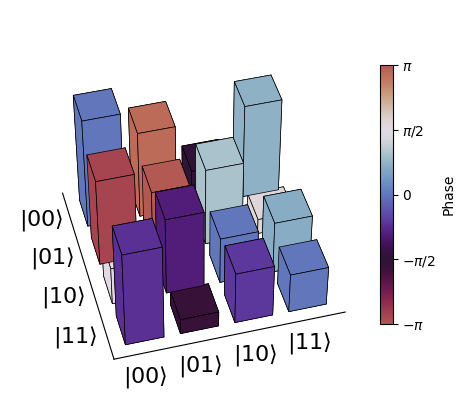

projection: (0.3945595672650666-3.628592062022166e-18j)


In [12]:
rho_height = coeff_groups_height.reconstruct_rho(abs_trace=True)
plot_complex_density_matrix(rho_height)
print(f"projection: {helper.projection_fortunato(rho_height, rho_theory)}")

## Second Approach: integrate the raw data
1. Integrate sample points using (`scipy.integrate.trapezoid`)
2. Integrate sample points using (`scipy.integrate.simpson`)

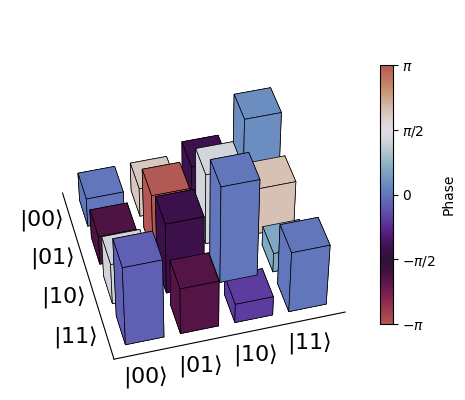

projection of naive integration: (-0.019600851015651635-3.610330084354057e-18j)


In [13]:
rho_naive = helper.integrate_simpson(freqs, all_spectra, p1_freqs, p2_freqs, INT_WIDTH)

plot_complex_density_matrix(rho_naive)
print(f"projection of naive integration: {helper.projection_fortunato(rho_naive, rho_theory)}")

### Integrating with various different parameters to find the integration with the largest projection value:

In [14]:
if not NO_IDENTITY:
    result_filename = f"result_{state_name}.pickle"
    error_filename = f"result_{state_name}_error.pickle"
else:
    result_filename = f"result_{state_name}_no_1.pickle"
    error_filename = f"result_{state_name}_no_1_error.pickle"

# Looking for result pickle file. If not found, optimize integration then save the results (& the error matrix)
try:
    with open(result_filename, "rb") as result_file:
        best_rho_simpson, best_projection, best_params = pickle.load(result_file)
        best_offsets, best_int_width, best_j_offset = best_params["offsets"], best_params["width"], best_params[
            "j_offset"]
    print("Found previously saved result file!")

except FileNotFoundError:
    print("Couldn't find saved result. Integrating and saving the result...")
    best_rho_simpson, best_projection, best_params, rho_error = \
        helper.integrate_optimized(freqs, all_spectra, p1_freqs, p2_freqs, rho_theory, return_error=True,
                                   j_offset_range=np.linspace(-1, 1, 11), #None
                                   add_identity=(not NO_IDENTITY), try_adding_neg=(not NO_IDENTITY))
    best_offsets, best_int_width, best_j_offset = best_params["offsets"], best_params["width"], best_params["j_offset"]
    with open(result_filename, "wb") as result_file:
        pickle.dump([best_rho_simpson, best_projection, best_params], result_file)
    with open(error_filename, "wb") as error_file:
        pickle.dump(rho_error, error_file)

# Looking for error pickle file. If not found, calculate & save the error matrix
try:
    with open(error_filename, "rb") as error_file:
        rho_error = pickle.load(error_file)
    print("Found previously saved error file")

except FileNotFoundError:  # in the case where result file exists but error file doesn't.
    print("Couldn't find saved error file. Calculating and saving error")
    rho_error = helper.integrate_simpson(freqs, all_spectra, p1_freqs, p2_freqs, best_int_width,
                                         best_offsets[0], best_offsets[1], return_error=True)
    with open(error_filename, "wb") as error_file:
        pickle.dump(rho_error, error_file)


Couldn't find saved result. Integrating and saving the result...
Found previously saved error file


Best projection: 0.5909348867830669
Best parameters: {'offsets': (-0.9, -1.0), 'width': 1, 'j_offset': 0.20000000000000018}
p_init_offsets: (1.5, 0.5)


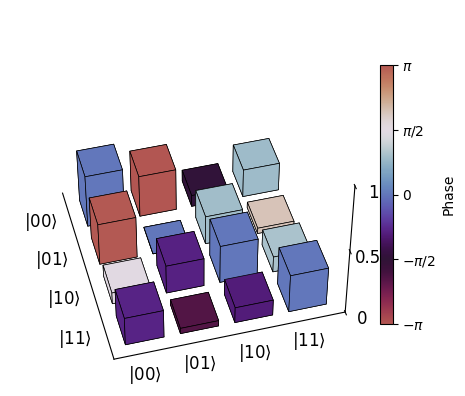

(<Figure size 640x480 with 2 Axes>, <Axes3D: >)

In [15]:
print(f"Best projection: {best_projection}")
print(f"Best parameters: {best_params}")
print(f"p_init_offsets: {p1_offset, p2_offset}")
plot_complex_density_matrix(best_rho_simpson, label_size=12, label_qubit=True, save_to="", hide_z_axis=False)

In [16]:
display(best_rho_simpson)

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 0.40563528+0.j         -0.32567394-0.00595268j  0.00295942-0.08975968j
   0.14318004+0.16662855j]
 [-0.32567394+0.00595268j  0.        +0.j          0.13800542+0.1748885j
  -0.01972995+0.03933986j]
 [ 0.00295942+0.08975968j  0.13800542-0.1748885j   0.29683856+0.j
   0.07037482+0.10186114j]
 [ 0.14318004-0.16662855j -0.01972995-0.03933986j  0.07037482-0.10186114j
   0.29752616+0.j        ]]

In [17]:
print(best_rho_simpson)

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 0.40563528+0.j         -0.32567394-0.00595268j  0.00295942-0.08975968j
   0.14318004+0.16662855j]
 [-0.32567394+0.00595268j  0.        +0.j          0.13800542+0.1748885j
  -0.01972995+0.03933986j]
 [ 0.00295942+0.08975968j  0.13800542-0.1748885j   0.29683856+0.j
   0.07037482+0.10186114j]
 [ 0.14318004-0.16662855j -0.01972995-0.03933986j  0.07037482-0.10186114j
   0.29752616+0.j        ]]


In [18]:
rho_non_neg = best_rho_simpson - op.IDENTITY * np.min(best_rho_simpson.diag())

In [19]:
helper.projection_fortunato(rho_non_neg, op.CLEAN_1000)

(0.45356264669646096+0j)

In [20]:
(rho_theory.sqrtm() * best_rho_simpson * rho_theory.sqrtm()).sqrtm() ** 2

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 2.64245793e-01+1.84742932e-19j -2.64245788e-01-1.53636100e-10j
   4.21821326e-10-2.54496460e-10j  3.61788548e-10+2.09095793e-10j]
 [-2.64245788e-01+1.53636100e-10j  2.64245783e-01+8.61926205e-20j
  -4.21821341e-10+2.54496475e-10j -3.61788544e-10-2.09095776e-10j]
 [-5.30817354e-10-1.50513973e-10j  5.30817344e-10+1.50513971e-10j
  -5.32261249e-18-3.08182075e-19j -2.78507563e-18+7.12104055e-19j]
 [ 1.64490615e-10-2.92976191e-10j -1.64490612e-10+2.92976185e-10j
  -3.42734145e-19+7.12104081e-19j  1.90469293e-18+3.08182084e-19j]]